In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
from astropy import wcs

from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter
from scipy import stats

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
nmad = lambda x: 1.4826 * np.median(np.abs(x-np.median(x)))

ccdnamenumdict = {'S1': 25, 'S2': 26, 'S3': 27, 'S4':28,
                  'S5': 29, 'S6': 30, 'S7': 31,
                  'S8': 19, 'S9': 20, 'S10': 21, 'S11': 22, 'S12': 23,
                  'S13': 24,
                  'S14': 13, 'S15': 14, 'S16': 15, 'S17': 16, 'S18': 17,
                  'S19': 18,
                  'S20': 8, 'S21': 9, 'S22': 10, 'S23': 11, 'S24': 12,
                  'S25': 4, 'S26': 5, 'S27': 6, 'S28': 7,
                  'S29': 1, 'S30': 2, 'S31': 3,
                  'N1': 32, 'N2': 33, 'N3': 34, 'N4': 35,
                  'N5': 36, 'N6': 37, 'N7': 38,
                  'N8': 39, 'N9': 40, 'N10': 41, 'N11': 42, 'N12': 43,
                  'N13': 44,
                  'N14': 45, 'N15': 46, 'N16': 47, 'N17': 48, 'N18': 49,
                  'N19': 50,
                  'N20': 51, 'N21': 52, 'N22': 53, 'N23': 54, 'N24': 55,
                  'N25': 56, 'N26': 57, 'N27': 58, 'N28': 59,
                  'N29': 60, 'N30': 61, 'N31': 62,
                  }
ccdnamenumdict_inv = {aa: bb for bb, aa in ccdnamenumdict.items()}

fringe_old_dir = '/global/homes/d/djschleg/cosmo/staging/decam/DECam_CP-Fringe'
fringe_new_dir = '/global/project/projectdirs/desi/users/rongpu/dr9/fringe/DECam_CP-Fringe'
image_dir = '/global/project/projectdirs/cosmo/staging/'
surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9-cut.fits.gz'
# surveyccd_path = '/global/u2/r/rongpu/temp/survey-ccds-decam-dr9-z-band-only-trim.fits'
blob_dir = '/global/cscratch1/sd/rongpu/fringe/decam_ccd_blob_mask'

# image_output_dir = '/global/cscratch1/sd/rongpu/fringe/fringe_corrected_image/'
frgscale_output_dir = '/global/cscratch1/sd/rongpu/fringe/frgscale/'
# image_output_dir = '/global/cscratch1/sd/rongpu/fringe/tmp_img/'
# frgscale_output_dir = '/global/cscratch1/sd/rongpu/fringe/tmp_frgscale/'

In [4]:
# Load CCD list
ccd_columns = ['image_filename', 'image_hdu', 'expnum', 'ccdname', 'filter', 'ccd_cuts']
ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
# ccd = fitsio.read(surveyccd_path)
ccd = Table(ccd)
mask = ccd['ccd_cuts']==0
mask &= ccd['filter']=='z' # include only z-band images
ccd = ccd[mask]
# print(len(ccd))
ccd['ccdnum'] = [ccdnamenumdict[ccd['ccdname'][ii].strip()] for ii in range(len(ccd))]

expnum_list = np.unique(ccd['expnum'])

# Find the exposures that have the fringe scales computed
expnum_list_done = np.zeros(len(expnum_list), dtype=bool)
for index, expnum in enumerate(expnum_list):
    # Find an arbitrary CCD in the exposure to get the image filename
    ccd_index = np.where((ccd['expnum']==expnum))[0][0]
    frgscale_output_path = os.path.join(frgscale_output_dir, ccd['image_filename'][ccd_index].strip().replace('.fits.fz', '.txt'))
    # Check that the file exist and not empty
    if os.path.isfile(frgscale_output_path) and (os.stat(frgscale_output_path).st_size != 0):
        expnum_list_done[index] = True
print(np.sum(expnum_list_done), np.sum(~expnum_list_done), np.sum(expnum_list_done)/len(expnum_list_done))

18854 165 0.991324465009


In [5]:
expnum_list = expnum_list[expnum_list_done]
print(len(expnum_list))

np.random.seed(321)
expnum_list = np.random.choice(expnum_list, size=1000, replace=False)
expnum_list.sort()

18854


In [6]:
print(np.array2string(expnum_list))

[233502 233508 233516 242707 242721 243035 243450 243452 243552 243578
 243586 251775 257545 257585 266690 266696 266699 266878 266884 266887
 266893 266898 268089 273741 345872 346605 346626 346634 346639 346640
 346646 346720 346732 346741 346743 346764 346766 346796 346929 346973
 346981 346985 346989 347007 347017 347049 347053 347063 347131 347273
 347386 347391 347420 347422 347476 347499 347506 347511 347686 347705
 347706 347710 347731 347742 347997 348058 348062 348063 348348 348648
 348650 348656 348747 348757 349158 349160 349183 349344 349348 349381
 349389 349416 349418 349431 349593 349841 349857 359269 364660 374558
 377003 377007 377108 377110 377130 377341 377374 377731 377739 377803
 378301 378313 378316 378322 378506 378580 378932 381798 381808 381814
 381823 381842 382205 382221 383202 383237 386072 386359 386383 387160
 387173 387453 387501 387840 387877 388243 391623 392022 393059 393120
 393167 393290 393492 393541 393552 393597 393598 395233 395510 395579
 39603

In [7]:
fringe_all = []

for expnum in expnum_list:

    # Find an arbitrary CCD in the exposure to get the image filename
    ccd_index = np.where((ccd['expnum']==expnum))[0][0]
    img_fn = os.path.join(image_dir, ccd['image_filename'][ccd_index].strip())
    
    frgscale_output_path = os.path.join(frgscale_output_dir, ccd['image_filename'][ccd_index].strip().replace('.fits.fz', '.txt'))
    
    fringe = Table.read(frgscale_output_path, format='ascii.commented_header')
    fringe.rename_column('slope', 'frgscale')
    
    # Remove outlier CCDs from computing median fringe scale
    ccdnum_exclude = [2, 16, 57] # S30, S17, N26
    mask = ~np.in1d(fringe['ccdnum'], ccdnum_exclude)
    
    frgscale_median = np.median(fringe['frgscale'][mask])
    fringe['relative_frg'] = fringe['frgscale'] / frgscale_median
    
    fringe_all.append(fringe)
    
fringe_stack = vstack(fringe_all)

In [8]:
print(len(fringe_stack))
fringe_stack[:3]

59352


expnum,ccdnum,frgscale_old,median_sky,sky_nmad,frgscale,intercept,r_value,p_value,std_err,relative_frg
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
233502,1,1400.781,1297.17089844,18.3846381592,848.34340862,0.0101713024944,0.00784405700627,2.58437971418e-52,55.7359323084,0.620183910569
233502,2,1400.781,1295.88024902,18.4830920654,140.436777133,0.0349169308477,0.00357282380731,4.31930033728e-13,19.3834679567,0.102666713439
233502,3,1400.781,1295.9744873,18.7236164062,1238.97764002,0.00116862326955,0.0152095201514,2.04684359526e-203,40.7100682655,0.905758198969


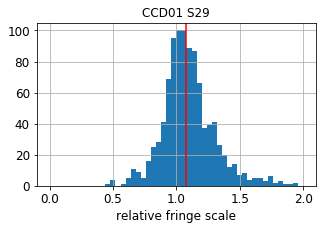

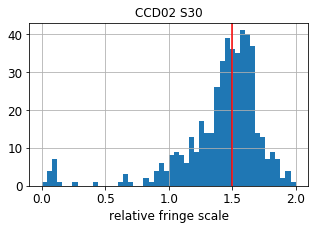

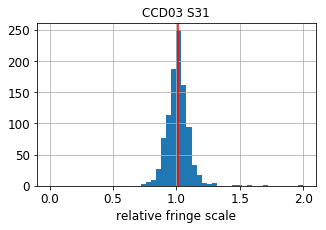

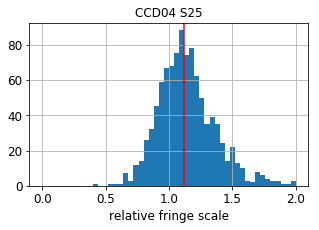

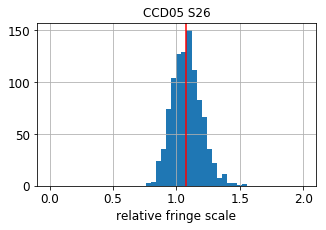

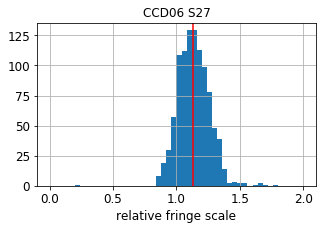

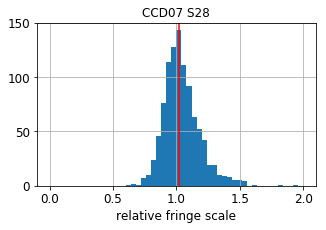

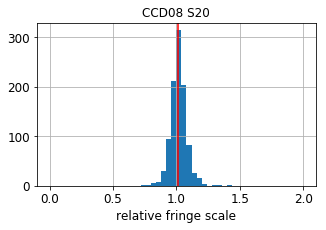

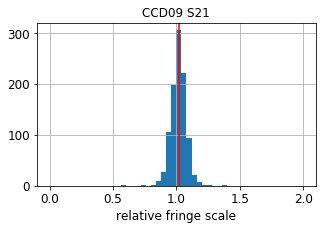

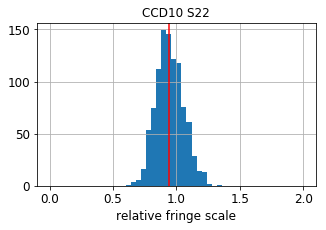

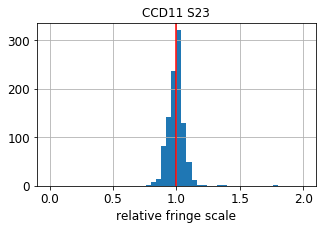

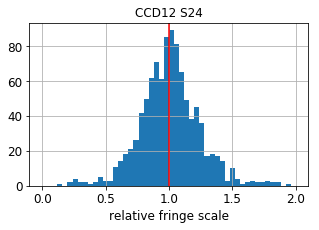

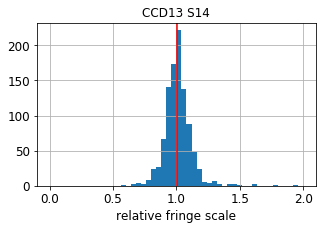

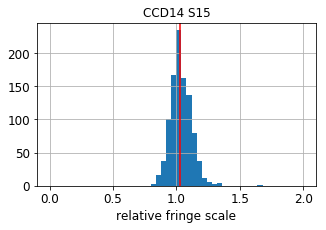

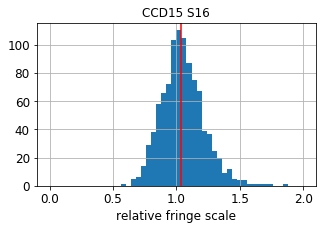

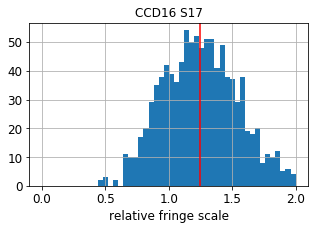

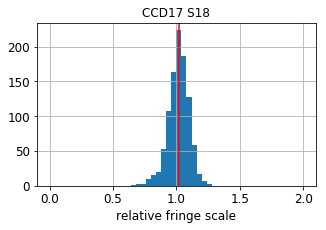

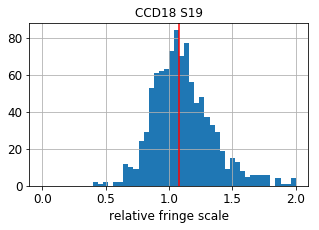

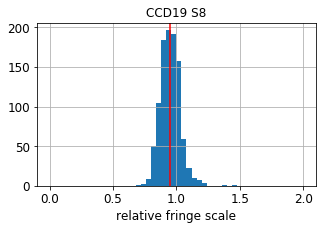

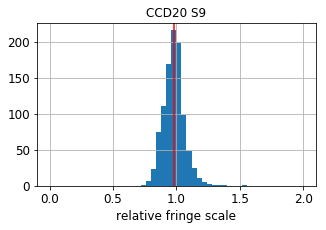

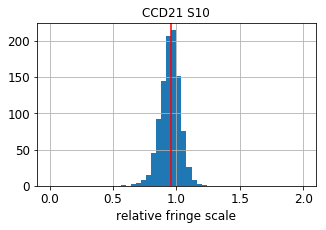

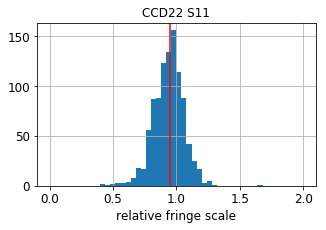

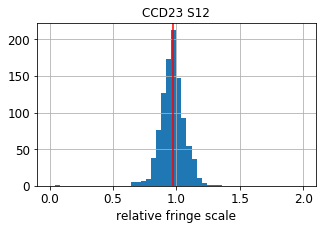

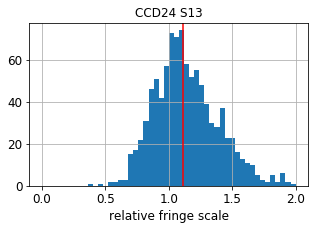

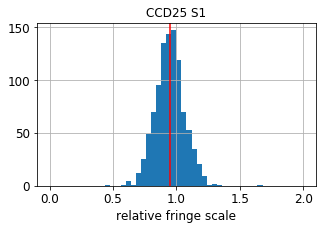

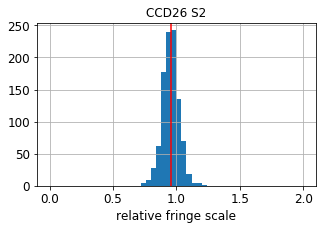

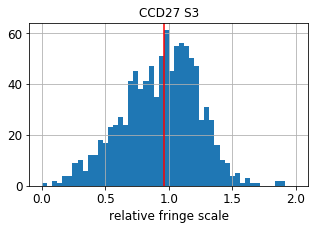

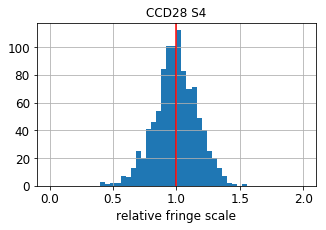

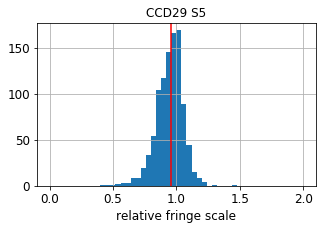

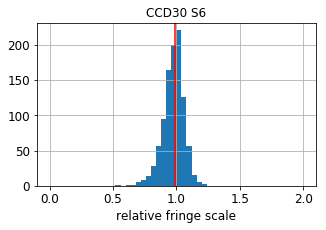

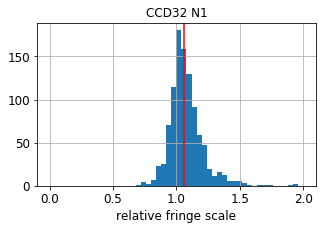

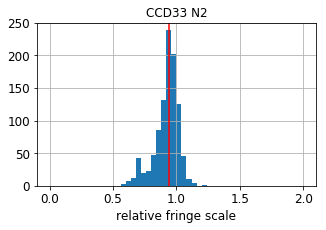

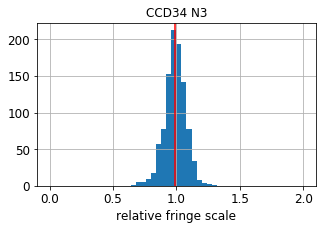

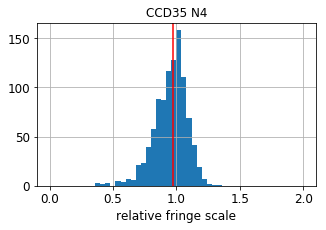

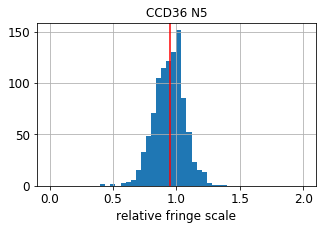

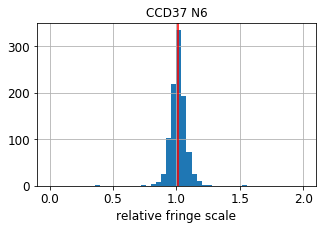

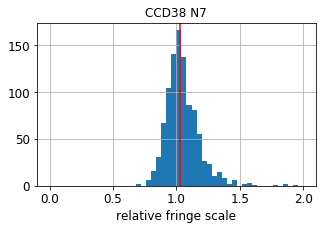

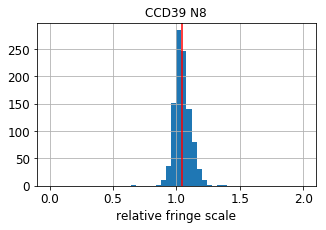

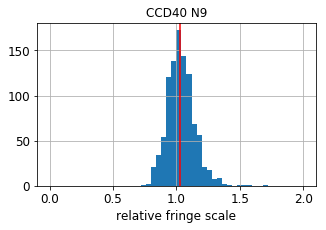

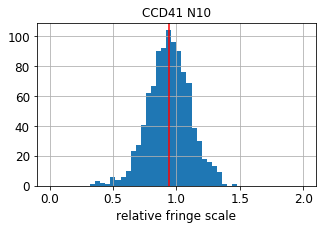

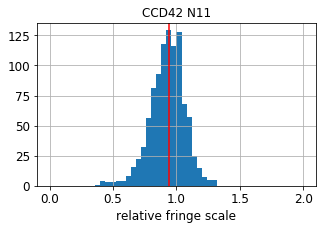

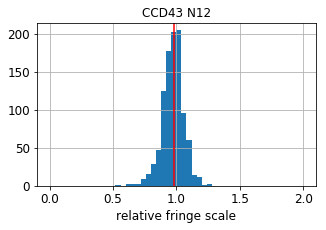

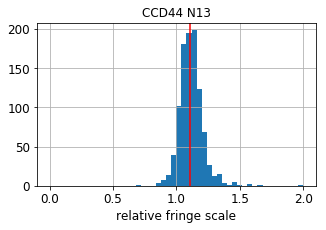

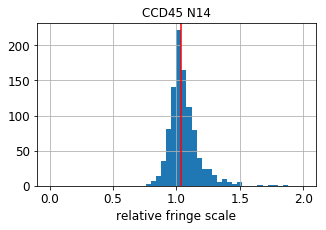

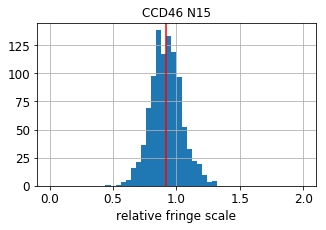

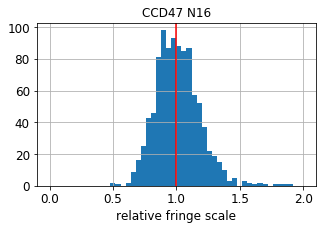

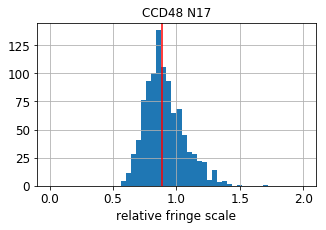

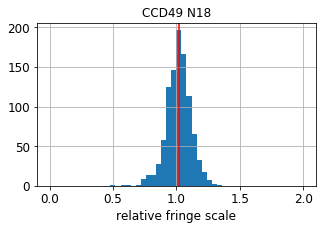

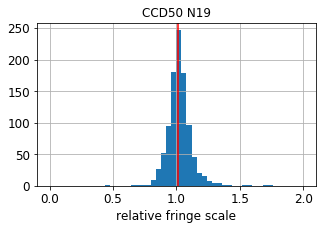

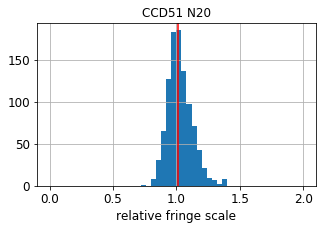

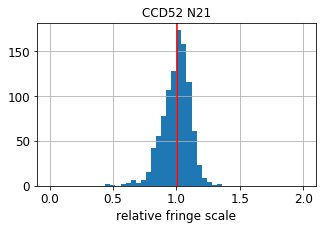

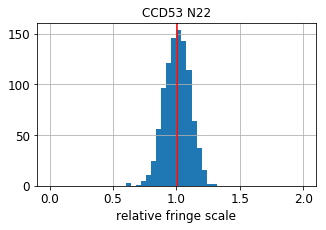

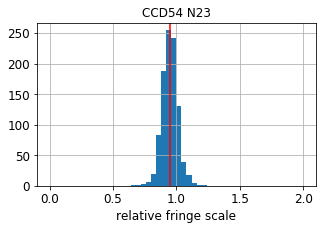

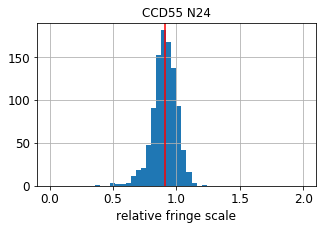

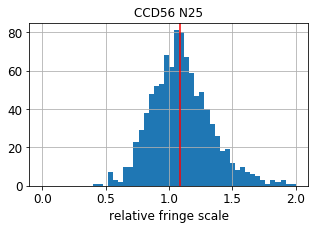

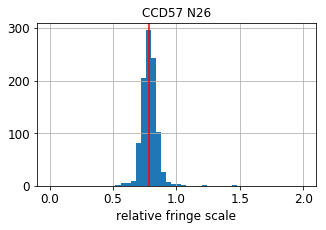

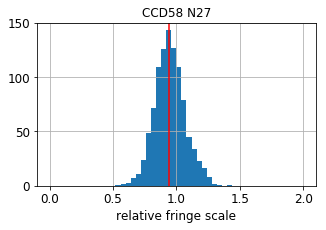

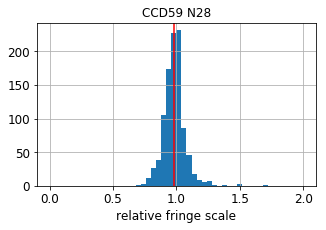

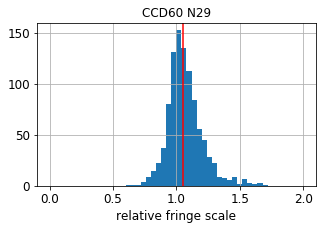

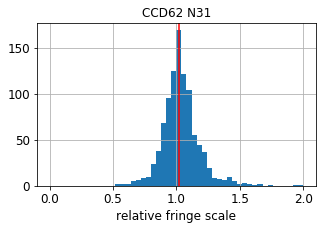

In [9]:
for ccdnum in np.unique(fringe_stack['ccdnum']):
    mask = fringe_stack['ccdnum']==ccdnum
    plt.figure(figsize=(5, 3))
    # plt.hist(fringe_stack['relative_frg'][mask], 50, range=(0, 2))
    plt.hist(fringe_stack['relative_frg'][mask], 50, range=(0, 2))
    plt.axvline(np.median(fringe_stack['relative_frg'][mask]), color='r')
    plt.xlabel('relative fringe scale')
    plt.title('CCD{} '.format(str(ccdnum).zfill(2))+ccdnamenumdict_inv[ccdnum])
    plt.grid()
    plt.show()

__Compute the normalization factor__

In [10]:
fringe_template_multiply = {}
print('ccdnum  ccdname norm_factor std')
for ccdnum in np.unique(fringe_stack['ccdnum']):
    mask = fringe_stack['ccdnum']==ccdnum
    norm_factor = np.median(fringe_stack['relative_frg'][mask])
    fringe_template_multiply[ccdnum] = norm_factor
    norm_factor_std = np.std(fringe_stack['relative_frg'][mask])
    print('{:3}     {:3}     {:5.3f}    {:5.3f}'.format(ccdnum, ccdnamenumdict_inv[ccdnum], norm_factor, norm_factor_std))

ccdnum  ccdname norm_factor std
  1     S29     1.074    0.423
  2     S30     1.500    0.359
  3     S31     1.010    0.161
  4     S25     1.120    0.257
  5     S26     1.080    0.120
  6     S27     1.130    0.157
  7     S28     1.023    0.212
  8     S20     1.016    0.092
  9     S21     1.018    0.060
 10     S22     0.943    0.108
 11     S23     1.000    0.065
 12     S24     1.000    0.269
 13     S14     1.002    0.192
 14     S15     1.030    0.097
 15     S16     1.040    0.522
 16     S17     1.244    0.312
 17     S18     1.019    0.082
 18     S19     1.082    0.529
 19     S8      0.951    0.077
 20     S9      0.979    0.099
 21     S10     0.958    0.105
 22     S11     0.948    0.127
 23     S12     0.971    0.094
 24     S13     1.113    0.385
 25     S1      0.950    0.153
 26     S2      0.956    0.067
 27     S3      0.963    0.300
 28     S4      0.998    0.166
 29     S5      0.960    0.108
 30     S6      0.986    0.083
 32     N1      1.058    0.189
 33    

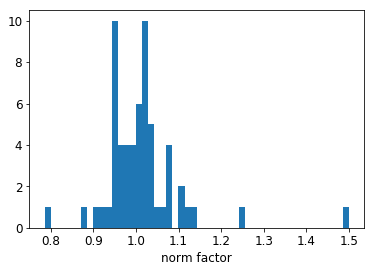

In [11]:
plt.hist(fringe_template_multiply.values(), 50)
plt.xlabel('norm factor')
plt.show()

In [12]:
# print('# ccdnum  norm_factor')
# for ii, jj in fringe_template_multiply.items():
#     print('{:8} {:7.3f}'.format(ii, jj))

__Apply the normalization__

In [32]:
fringe_normed_dir = '/global/project/projectdirs/desi/users/rongpu/dr9/fringe/DECam_CP-Fringe-Normed'

for ccdnum in np.unique(fringe_stack['ccdnum']):
    ccdname = ccdnamenumdict_inv[ccdnum]
    fringe_path = os.path.join(fringe_new_dir, 'DECam_z_frg_{}_CCD{}.fits'.format(ccdname, str(ccdnum).zfill(2)))
    with fits.open(fringe_path) as hdul:
        hdul[0].data = hdul[0].data * fringe_template_multiply[ccdnum]
        fringe_normed_path = os.path.join(fringe_normed_dir, 'DECam_z_frg_{}_CCD{}.fits'.format(ccdname, str(ccdnum).zfill(2)))
        hdul.writeto(fringe_normed_path)

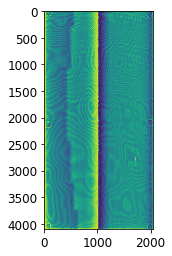

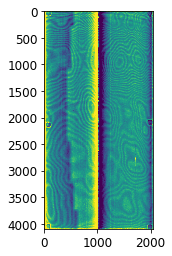

In [36]:
for ccdnum in [2]:
    ccdname = ccdnamenumdict_inv[ccdnum]
    fringe_path = os.path.join(fringe_new_dir, 'DECam_z_frg_{}_CCD{}.fits'.format(ccdname, str(ccdnum).zfill(2)))
    fringe_normed_path = os.path.join(fringe_normed_dir, 'DECam_z_frg_{}_CCD{}.fits'.format(ccdname, str(ccdnum).zfill(2)))
    with fits.open(fringe_path) as hdul:
        data = hdul[0].data
        plt.imshow(data, vmin=data.min(), vmax=data.max())
        plt.show()
    with fits.open(fringe_normed_path) as hdul:
        data1 = hdul[0].data
        plt.imshow(data1, vmin=data.min(), vmax=data.max())
        plt.show()